# DiD com Controles para 3G - Versão Otimizada

Este notebook usa seus dados reais de 3G para estimar modelos DiD controlando adequadamente por tecnologias pré-existentes.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Módulos carregados")

✅ Módulos carregados


## 1. Carregar Dados

In [2]:
# Polarização
painel_pol = pd.read_csv('painel_polarizacao_municipal_2010_2022.csv', dtype={'codigo_tse': str})

# 4G
dados_4g = pd.read_csv('municipios_4g_com_codigo_tse.csv', dtype={'codigo_tse': str})

# 3G
dados_3g = pd.read_csv('municipios_3g_com_codigo_tse.csv', dtype={'codigo_tse': str})

print(f"\n📊 DADOS CARREGADOS:")
print(f"\nPolarização:")
print(f"  Observações: {len(painel_pol):,}")
print(f"  Municípios: {painel_pol['codigo_tse'].nunique():,}")
print(f"  Anos: {sorted(painel_pol['ano'].unique())}")

print(f"\n4G:")
print(f"  Municípios: {len(dados_4g):,}")
print(f"  Colunas disponíveis: {[col for col in dados_4g.columns if '4g' in col.lower()]}")

print(f"\n3G:")
print(f"  Municípios: {len(dados_3g):,}")
print(f"  Colunas disponíveis: {[col for col in dados_3g.columns if '3g' in col.lower()]}")


📊 DADOS CARREGADOS:

Polarização:
  Observações: 22,837
  Municípios: 5,752
  Anos: [np.int64(2010), np.int64(2014), np.int64(2018), np.int64(2022)]

4G:
  Municípios: 4,612
  Colunas disponíveis: ['primeira_estacao_4g', 'ano_primeira_4g', 'mes_primeira_4g', 'n_estacoes_4g_total', 'tem_4g_2010', 'tem_4g_2014', 'tem_4g_2018', 'tem_4g_2022', 'anos_com_4g_2014', 'anos_com_4g_2018', 'anos_com_4g_2022']

3G:
  Municípios: 5,524
  Colunas disponíveis: ['primeira_estacao_3g', 'ano_primeira_3g', 'mes_primeira_3g', 'n_estacoes_3g_total', 'tem_3g_2010', 'tem_3g_2014', 'tem_3g_2018', 'tem_3g_2022', 'anos_com_3g_2014', 'anos_com_3g_2018', 'anos_com_3g_2022']


## 2. Preparar Dados para Merge

In [3]:
# Preparar 4G
colunas_4g = [
    'codigo_tse', 
    'tem_4g_2014', 
    'tem_4g_2018',
    'anos_com_4g_2014',
    'anos_com_4g_2018',
    'ano_primeira_4g',
    'uf',
    'faixa_primeira'
]

dados_4g_merge = dados_4g[colunas_4g].copy()

# Preparar 3G - usando suas colunas reais
colunas_3g = [
    'codigo_tse',
    'tem_3g_2014',
    'tem_3g_2018',
    'anos_com_3g_2014',
    'anos_com_3g_2018',
    'ano_primeira_3g',
    'n_estacoes_3g_total'
]

dados_3g_merge = dados_3g[colunas_3g].copy()

print(f"\n✅ Dados preparados:")
print(f"  4G: {len(dados_4g_merge):,} municípios")
print(f"  3G: {len(dados_3g_merge):,} municípios")


✅ Dados preparados:
  4G: 4,612 municípios
  3G: 5,524 municípios


## 3. Merge Estratégico

In [4]:
# Estratégia: inner com 4G, left com 3G
print("\n🔄 REALIZANDO MERGE:")

# Passo 1: Polarização + 4G
painel_completo = painel_pol.merge(
    dados_4g_merge,
    on='codigo_tse',
    how='inner',
    indicator=True
)

print(f"\nApós merge com 4G:")
print(f"  Observações: {len(painel_completo):,}")
print(f"  Municípios: {painel_completo['codigo_tse'].nunique():,}")

merge_4g = painel_completo['_merge'].value_counts()
print(f"  Both: {merge_4g.get('both', 0):,}")
print(f"  Left only: {merge_4g.get('left_only', 0):,}")
print(f"  Right only: {merge_4g.get('right_only', 0):,}")

painel_completo = painel_completo.drop('_merge', axis=1)

# Passo 2: Adicionar 3G (LEFT JOIN)
painel_completo = painel_completo.merge(
    dados_3g_merge,
    on='codigo_tse',
    how='left',
    indicator=True
)

print(f"\nApós merge com 3G:")
print(f"  Observações: {len(painel_completo):,}")
print(f"  Municípios: {painel_completo['codigo_tse'].nunique():,}")

merge_3g = painel_completo['_merge'].value_counts()
print(f"  Both (tem dados 3G): {merge_3g.get('both', 0):,}")
print(f"  Left only (sem dados 3G): {merge_3g.get('left_only', 0):,}")

# Análise dos missings
print(f"\n📊 MISSINGS EM 3G:")
for col in ['tem_3g_2014', 'tem_3g_2018', 'anos_com_3g_2014', 'anos_com_3g_2018']:
    n_missing = painel_completo[col].isna().sum()
    pct_missing = n_missing / len(painel_completo) * 100
    print(f"  {col}: {n_missing:,} ({pct_missing:.1f}%)")

painel_completo = painel_completo.drop('_merge', axis=1)


🔄 REALIZANDO MERGE:

Após merge com 4G:
  Observações: 16,489
  Municípios: 4,123
  Both: 16,489
  Left only: 0
  Right only: 0

Após merge com 3G:
  Observações: 16,489
  Municípios: 4,123
  Both (tem dados 3G): 16,377
  Left only (sem dados 3G): 112

📊 MISSINGS EM 3G:
  tem_3g_2014: 112 (0.7%)
  tem_3g_2018: 112 (0.7%)
  anos_com_3g_2014: 112 (0.7%)
  anos_com_3g_2018: 112 (0.7%)


## 4. Criar Variáveis

In [5]:
# Post (período pós-tratamento)
painel_completo['post'] = (painel_completo['ano'] == 2018).astype(int)

# 4G por ano
painel_completo['tem_4g'] = np.where(
    painel_completo['ano'] == 2014,
    painel_completo['tem_4g_2014'],
    painel_completo['tem_4g_2018']
)

painel_completo['anos_4g'] = np.where(
    painel_completo['ano'] == 2014,
    painel_completo['anos_com_4g_2014'],
    painel_completo['anos_com_4g_2018']
)

# 3G por ano (PREENCHENDO MISSINGS)
# Se não tem dados de 3G, assumir que NÃO tinha (conservador)
painel_completo['tem_3g'] = np.where(
    painel_completo['ano'] == 2014,
    painel_completo['tem_3g_2014'].fillna(0),
    painel_completo['tem_3g_2018'].fillna(0)
)

painel_completo['anos_3g'] = np.where(
    painel_completo['ano'] == 2014,
    painel_completo['anos_com_3g_2014'].fillna(0),
    painel_completo['anos_com_3g_2018'].fillna(0)
)

# Grupos de tratamento
def classificar_grupo(row):
    if row['tem_4g_2014'] == 1 and row['tem_4g_2018'] == 1:
        return 'sempre_tratado'
    elif row['tem_4g_2014'] == 0 and row['tem_4g_2018'] == 1:
        return 'tratado_2018'
    elif row['tem_4g_2014'] == 0 and row['tem_4g_2018'] == 0:
        return 'nunca_tratado'
    else:
        return 'outro'

painel_completo['grupo_tratamento'] = painel_completo.apply(classificar_grupo, axis=1)

# Interação DiD
painel_completo['post_x_4g'] = painel_completo['post'] * painel_completo['tem_4g']

print("\n✅ VARIÁVEIS CRIADAS")
print("\nDistribuição por ano:")
for ano in [2014, 2018]:
    df_ano = painel_completo[painel_completo['ano'] == ano]
    print(f"\n{ano}:")
    print(f"  3G: {df_ano['tem_3g'].sum():,} ({df_ano['tem_3g'].mean()*100:.1f}%)")
    print(f"  4G: {df_ano['tem_4g'].sum():,} ({df_ano['tem_4g'].mean()*100:.1f}%)")


✅ VARIÁVEIS CRIADAS

Distribuição por ano:

2014:
  3G: 3,614.0 (87.7%)
  4G: 879 (21.3%)

2018:
  3G: 3,957.0 (96.0%)
  4G: 2,420 (58.7%)


## 5. Análise de Sobreposição 3G-4G


            Municípios  Percentual (%)
categoria                            
3G + 4G          2419           58.67
Apenas 3G        1538           37.30
Nenhuma           165            4.00
Apenas 4G           1            0.02

✅ Gráfico salvo: sobreposicao_3g_4g.png


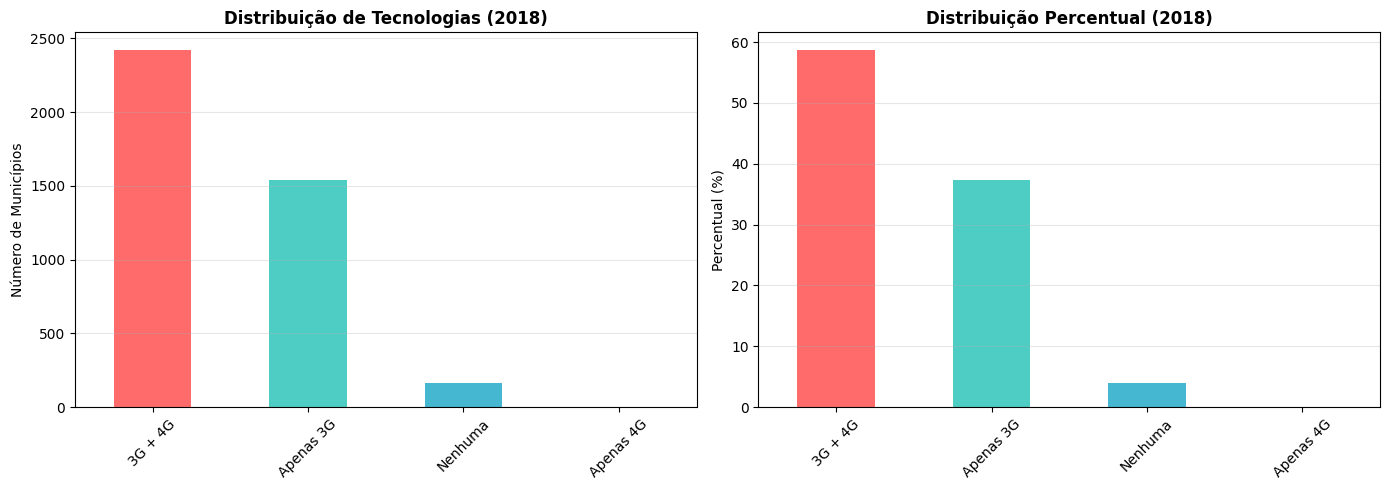


----------------------------------------------------------------------
IMPLICAÇÕES PARA IDENTIFICAÇÃO:
----------------------------------------------------------------------

• Municípios com 4G mas sem 3G: 0.02%
• Municípios com 4G e 3G: 58.67%

⚠️  CRÍTICO: Poucos municípios têm 4G sem ter tido 3G!
   Implicação: Difícil separar efeito incremental do 4G.
   Interpretação: O 'efeito do 4G' é principalmente upgrade de 3G→4G.
   Solução: Controlar por 3G é ESSENCIAL para identificação.


In [6]:
#Análise de sobreposição
df_2018 = painel_completo[painel_completo['ano'] == 2018].copy()

# Criar categorias combinadas
df_2018['categoria'] = 'Nenhuma'
df_2018.loc[(df_2018['tem_3g'] == 1) & (df_2018['tem_4g'] == 0), 'categoria'] = 'Apenas 3G'
df_2018.loc[(df_2018['tem_3g'] == 0) & (df_2018['tem_4g'] == 1), 'categoria'] = 'Apenas 4G'
df_2018.loc[(df_2018['tem_3g'] == 1) & (df_2018['tem_4g'] == 1), 'categoria'] = '3G + 4G'

distribuicao = df_2018['categoria'].value_counts()
pct = (distribuicao / len(df_2018) * 100).round(2)

resultado = pd.DataFrame({
    'Municípios': distribuicao,
    'Percentual (%)': pct
})

print("\n", resultado)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Contagens
resultado['Municípios'].plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
ax1.set_title('Distribuição de Tecnologias (2018)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Número de Municípios')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3, axis='y')

# Gráfico 2: Percentuais
resultado['Percentual (%)'].plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3'])
ax2.set_title('Distribuição Percentual (2018)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Percentual (%)')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sobreposicao_3g_4g.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico salvo: sobreposicao_3g_4g.png")
plt.show()

# Implicações para identificação
pct_4g_sem_3g = resultado.loc['Apenas 4G', 'Percentual (%)'] if 'Apenas 4G' in resultado.index else 0
pct_4g_com_3g = resultado.loc['3G + 4G', 'Percentual (%)'] if '3G + 4G' in resultado.index else 0

print("\n" + "-"*70)
print("IMPLICAÇÕES PARA IDENTIFICAÇÃO:")
print("-"*70)
print(f"\n• Municípios com 4G mas sem 3G: {pct_4g_sem_3g:.2f}%")
print(f"• Municípios com 4G e 3G: {pct_4g_com_3g:.2f}%")

if pct_4g_sem_3g < 5:
    print("\n⚠️  CRÍTICO: Poucos municípios têm 4G sem ter tido 3G!")
    print("   Implicação: Difícil separar efeito incremental do 4G.")
    print("   Interpretação: O 'efeito do 4G' é principalmente upgrade de 3G→4G.")
    print("   Solução: Controlar por 3G é ESSENCIAL para identificação.")
elif pct_4g_sem_3g < 15:
    print("\n⚠️  ATENÇÃO: Relativamente poucos municípios com 4G mas sem 3G.")
    print("   Implicação: Alguma variação para identificar efeito incremental.")
    print("   Interpretação: Controlar por 3G é importante.")
else:
    print("\n✅ Boa variação: há municípios suficientes com 4G mas sem 3G.")
    print("   Implicação: Possível separar efeito incremental do 4G.")

## 6. Preparar Dados para DiD (CRÍTICO)

In [7]:
print("\n🔧 PREPARANDO DADOS PARA DiD:")

# Filtrar apenas grupos relevantes
df_did = painel_completo[
    painel_completo['grupo_tratamento'].isin(['nunca_tratado', 'tratado_2018'])
].copy()

print(f"\nApós filtrar grupos:")
print(f"  Observações: {len(df_did):,}")
print(f"  Municípios: {df_did['codigo_tse'].nunique():,}")

# Listar TODAS as variáveis que vamos usar
variaveis_modelo = [
    'esteban_ray',      # Outcome
    'post',             # Tempo
    'tem_4g',           # Tratamento
    'post_x_4g',        # Interação DiD
    'tem_3g',           # Controle 1
    'anos_3g',          # Controle 2
    'codigo_tse'        # Clustering
]

# Verificar NaNs ANTES de remover
print(f"\n📊 VERIFICANDO NaNs:")
for var in variaveis_modelo:
    n_nan = df_did[var].isna().sum()
    if n_nan > 0:
        pct_nan = n_nan / len(df_did) * 100
        print(f"  ⚠️  {var}: {n_nan:,} NaNs ({pct_nan:.2f}%)")
    else:
        print(f"  ✅ {var}: sem NaNs")

# CRÍTICO: Remover NaNs
df_did_clean = df_did[variaveis_modelo].dropna()

print(f"\nApós remover NaNs:")
print(f"  Observações: {len(df_did_clean):,}")
print(f"  Municípios: {df_did_clean['codigo_tse'].nunique():,}")
print(f"  Observações removidas: {len(df_did) - len(df_did_clean):,} ({(1 - len(df_did_clean)/len(df_did))*100:.1f}%)")

# Verificações finais
assert df_did_clean['codigo_tse'].isna().sum() == 0, "❌ Erro: codigo_tse tem NaNs!"
assert len(df_did_clean) > 0, "❌ Erro: DataFrame vazio após limpeza!"

print("\n✅ Dados prontos para modelagem!")

# Estatísticas descritivas do dataset limpo
print(f"\n📊 ESTATÍSTICAS DO DATASET LIMPO:")
print(f"\nPolarização (Esteban-Ray):")
print(f"  Média: {df_did_clean['esteban_ray'].mean():.4f}")
print(f"  Mediana: {df_did_clean['esteban_ray'].median():.4f}")
print(f"  Desvio: {df_did_clean['esteban_ray'].std():.4f}")

print(f"\nCobertura de tecnologias:")
print(f"  3G: {df_did_clean['tem_3g'].sum():,} obs ({df_did_clean['tem_3g'].mean()*100:.1f}%)")
print(f"  4G: {df_did_clean['tem_4g'].sum():,} obs ({df_did_clean['tem_4g'].mean()*100:.1f}%)")


🔧 PREPARANDO DADOS PARA DiD:

Após filtrar grupos:
  Observações: 12,973
  Municípios: 3,244

📊 VERIFICANDO NaNs:
  ✅ esteban_ray: sem NaNs
  ✅ post: sem NaNs
  ✅ tem_4g: sem NaNs
  ✅ post_x_4g: sem NaNs
  ✅ tem_3g: sem NaNs
  ✅ anos_3g: sem NaNs
  ✅ codigo_tse: sem NaNs

Após remover NaNs:
  Observações: 12,973
  Municípios: 3,244
  Observações removidas: 0 (0.0%)

✅ Dados prontos para modelagem!

📊 ESTATÍSTICAS DO DATASET LIMPO:

Polarização (Esteban-Ray):
  Média: 0.0746
  Mediana: 0.0692
  Desvio: 0.0325

Cobertura de tecnologias:
  3G: 11,966.0 obs (92.2%)
  4G: 4,621 obs (35.6%)


## 7. Modelo DiD NAIVE (sem controles)

In [8]:
formula_naive = 'esteban_ray ~ post + tem_4g + post_x_4g'

modelo_naive = smf.ols(formula_naive, data=df_did_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_did_clean['codigo_tse']}
)

print("\n", modelo_naive.summary())

# Guardar para comparação
did_effect = modelo_naive.params['post_x_4g']
did_se = modelo_naive.bse['post_x_4g']
did_pvalue = modelo_naive.pvalues['post_x_4g']
media_baseline = df_did_clean[df_did_clean['post'] == 0]['esteban_ray'].mean()
efeito_pct = (did_effect / media_baseline) * 100

print(f"\n" + "-"*70)
print("📊 INTERPRETAÇÃO:")
print("-"*70)
print(f"\nEfeito DiD: {did_effect:.6f}")
print(f"Erro padrão: {did_se:.6f}")
print(f"P-valor: {did_pvalue:.4f}")
print(f"IC 95%: [{did_effect - 1.96*did_se:.6f}, {did_effect + 1.96*did_se:.6f}]")
print(f"\nEfeito em %: {efeito_pct:+.2f}% da linha de base")
print(f"Significância: {'✅ Significativo a 5%' if did_pvalue < 0.05 else '❌ Não significativo a 5%'}")
print(f"\nR²: {modelo_naive.rsquared:.4f}")
print(f"N: {modelo_naive.nobs:,.0f}")


                             OLS Regression Results                            
Dep. Variable:            esteban_ray   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     2830.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:15:31   Log-Likelihood:                 26924.
No. Observations:               12973   AIC:                        -5.384e+04
Df Residuals:                   12969   BIC:                        -5.381e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0783      0.000    220.909      0

## 8. Modelo DiD COM CONTROLES para 3G

In [11]:
# Fórmula com controles
formula_controls = 'esteban_ray ~ post + tem_4g + post_x_4g + tem_3g + tem_3g:post + anos_3g'

modelo_controls = smf.ols(formula_controls, data=df_did_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_did_clean['codigo_tse']}
)

print("\n", modelo_controls.summary())

# Extrair resultados
did_effect_controls = modelo_controls.params['post_x_4g']
did_se_controls = modelo_controls.bse['post_x_4g']
did_pvalue_controls = modelo_controls.pvalues['post_x_4g']
efeito_pct_controls = (did_effect_controls / media_baseline) * 100

print(f"\n" + "-"*70)
print("📊 INTERPRETAÇÃO:")
print("-"*70)
print(f"\nEfeito DiD (com controles): {did_effect_controls:.6f}")
print(f"Erro padrão: {did_se_controls:.6f}")
print(f"P-valor: {did_pvalue_controls:.4f}")
print(f"IC 95%: [{did_effect_controls - 1.96*did_se_controls:.6f}, {did_effect_controls + 1.96*did_se_controls:.6f}]")
print(f"\nEfeito em %: {efeito_pct_controls:+.2f}% da linha de base")
print(f"Significância: {'✅ Significativo a 5%' if did_pvalue_controls < 0.05 else '❌ Não significativo a 5%'}")
print(f"\nR²: {modelo_controls.rsquared:.4f}")
print(f"N: {modelo_controls.nobs:,.0f}")

# Analisar controles
print(f"\n" + "-"*70)
print("📊 EFEITOS DOS CONTROLES:")
print("-"*70)

print(f"\nTem 3G (efeito direto):")
print(f"  Coef: {modelo_controls.params['tem_3g']:.6f}")
print(f"  P-valor: {modelo_controls.pvalues['tem_3g']:.4f}")
print(f"  {'✅ Significativo' if modelo_controls.pvalues['tem_3g'] < 0.05 else '❌ Não significativo'}")

print(f"\nTem 3G × Post (interação temporal):")
print(f"  Coef: {modelo_controls.params['tem_3g:post']:.6f}")
print(f"  P-valor: {modelo_controls.pvalues['tem_3g:post']:.4f}")
print(f"  {'✅ Significativo' if modelo_controls.pvalues['tem_3g:post'] < 0.05 else '❌ Não significativo'}")

print(f"\nAnos de 3G (dose-resposta):")
print(f"  Coef: {modelo_controls.params['anos_3g']:.6f}")
print(f"  P-valor: {modelo_controls.pvalues['anos_3g']:.4f}")
print(f"  {'✅ Significativo' if modelo_controls.pvalues['anos_3g'] < 0.05 else '❌ Não significativo'}")


                             OLS Regression Results                            
Dep. Variable:            esteban_ray   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     1582.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:20:46   Log-Likelihood:                 27177.
No. Observations:               12973   AIC:                        -5.434e+04
Df Residuals:                   12966   BIC:                        -5.429e+04
Df Model:                           6                                         
Covariance Type:              cluster                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0756      0.001     75.977    

## 9. Comparação Sistemática


COMPARAÇÃO: SEM CONTROLES vs COM CONTROLES

    Especificação   Coef 4G       SE      P-valor   Efeito %       R²       N Sig.
   Sem controles -0.013064 0.000647 8.896913e-91 -16.122215 0.128411 12973.0  ***
Com controles 3G -0.011100 0.000658 6.280461e-64 -13.698837 0.161645 12973.0  ***

Notas: *** p<0.01, ** p<0.05, * p<0.10

----------------------------------------------------------------------
IMPACTO DOS CONTROLES:
----------------------------------------------------------------------

Diferença no coeficiente: 0.001964
Mudança percentual: -15.03%

Interpretação:

⚠️  IMPACTO SUBSTANCIAL (10-20%)
   → Havia confounding importante com 3G
   → Parte do 'efeito do 4G' era na verdade efeito do 3G
   → Usar especificação com controles

✅ Gráfico salvo: comparacao_com_sem_controles.png


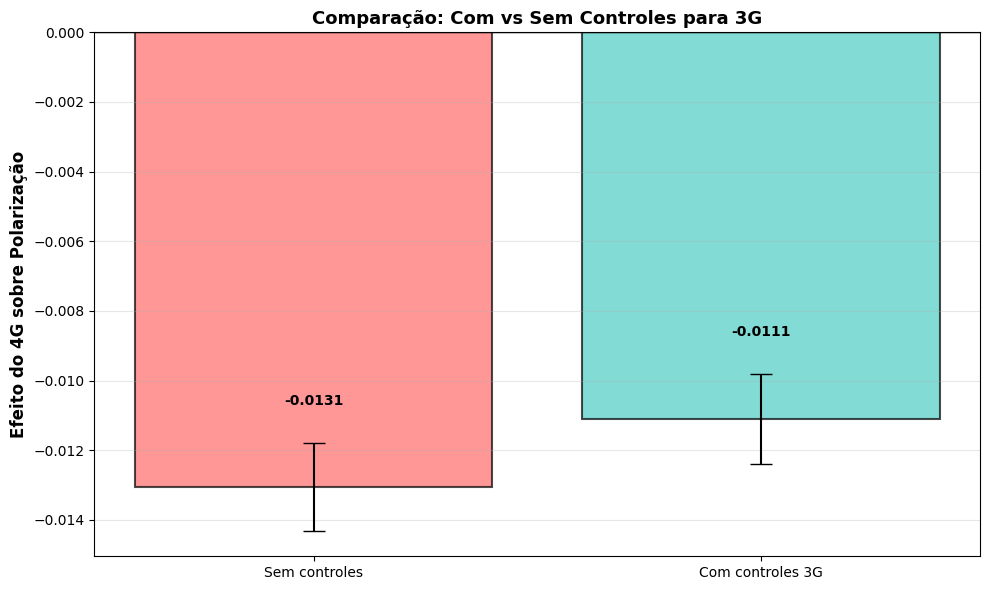

In [12]:
print("\n" + "="*70)
print("COMPARAÇÃO: SEM CONTROLES vs COM CONTROLES")
print("="*70)

# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Especificação': ['Sem controles', 'Com controles 3G'],
    'Coef 4G': [did_effect, did_effect_controls],
    'SE': [did_se, did_se_controls],
    'P-valor': [did_pvalue, did_pvalue_controls],
    'Efeito %': [efeito_pct, efeito_pct_controls],
    'R²': [modelo_naive.rsquared, modelo_controls.rsquared],
    'N': [modelo_naive.nobs, modelo_controls.nobs]
})

comparacao['Sig.'] = comparacao['P-valor'].apply(
    lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else ''))
)

print("\n", comparacao.to_string(index=False))
print("\nNotas: *** p<0.01, ** p<0.05, * p<0.10")

# Análise da mudança
diff_coef = did_effect_controls - did_effect
diff_pct = (diff_coef / did_effect) * 100 if did_effect != 0 else 0

print(f"\n" + "-"*70)
print("IMPACTO DOS CONTROLES:")
print("-"*70)
print(f"\nDiferença no coeficiente: {diff_coef:.6f}")
print(f"Mudança percentual: {diff_pct:+.2f}%")
print(f"\nInterpretação:")

if abs(diff_pct) > 20:
    print("\n⚠️  IMPACTO MUITO GRANDE (>20%)!")
    print("   → Havia confounding SEVERO com 3G")
    print("   → Sem controles, o efeito estava MUITO enviesado")
    print("   → ESSENCIAL usar especificação com controles")
elif abs(diff_pct) > 10:
    print("\n⚠️  IMPACTO SUBSTANCIAL (10-20%)")
    print("   → Havia confounding importante com 3G")
    print("   → Parte do 'efeito do 4G' era na verdade efeito do 3G")
    print("   → Usar especificação com controles")
elif abs(diff_pct) > 5:
    print("\n⚠️  Impacto moderado (5-10%)")
    print("   → Algum confounding com 3G")
    print("   → Preferir especificação com controles")
else:
    print("\n✅ Impacto pequeno (<5%)")
    print("   → Pouco confounding com 3G")
    print("   → Efeito do 4G é robusto")
    print("   → Mas ainda assim, reportar ambas as especificações")

# Visualização
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = [0, 1]
coefs = [did_effect, did_effect_controls]
ses = [did_se, did_se_controls]

colors = ['#FF6B6B', '#4ECDC4']
labels = ['Sem controles', 'Com controles 3G']

ax.bar(x_pos, coefs, yerr=[1.96*se for se in ses], 
       alpha=0.7, capsize=8, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Efeito do 4G sobre Polarização', fontsize=12, fontweight='bold')
ax.set_title('Comparação: Com vs Sem Controles para 3G', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Adicionar valores nos bars
for i, (coef, se) in enumerate(zip(coefs, ses)):
    ax.text(i, coef + 1.96*se + 0.001, f'{coef:.4f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacao_com_sem_controles.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico salvo: comparacao_com_sem_controles.png")
plt.show()

## 10. Salvar Resultados

In [13]:
# Salvar painel completo
painel_completo.to_csv('painel_completo_com_3g.csv', index=False)
print(f"✅ Salvo: painel_completo_com_3g.csv ({len(painel_completo):,} obs)")

# Salvar dados limpos para DiD
df_did_clean.to_csv('painel_did_limpo.csv', index=False)
print(f"✅ Salvo: painel_did_limpo.csv ({len(df_did_clean):,} obs)")

# Salvar tabela de resultados
comparacao.to_csv('resultados_comparacao_controles.csv', index=False)
print(f"✅ Salvo: resultados_comparacao_controles.csv")

print("\n" + "="*70)
print("✅ ANÁLISE COMPLETA!")
print("="*70)
print("\nArquivos gerados:")
print("  1. painel_completo_com_3g.csv - Dados completos")
print("  2. painel_did_limpo.csv - Dados prontos para modelagem")
print("  3. resultados_comparacao_controles.csv - Tabela de resultados")
print("  4. sobreposicao_3g_4g.png - Gráfico de sobreposição")
print("  5. comparacao_com_sem_controles.png - Gráfico de comparação")

✅ Salvo: painel_completo_com_3g.csv (16,489 obs)
✅ Salvo: painel_did_limpo.csv (12,973 obs)
✅ Salvo: resultados_comparacao_controles.csv

✅ ANÁLISE COMPLETA!

Arquivos gerados:
  1. painel_completo_com_3g.csv - Dados completos
  2. painel_did_limpo.csv - Dados prontos para modelagem
  3. resultados_comparacao_controles.csv - Tabela de resultados
  4. sobreposicao_3g_4g.png - Gráfico de sobreposição
  5. comparacao_com_sem_controles.png - Gráfico de comparação
